In [2]:
from pathlib import Path
from collections import defaultdict

from Bio.Phylo.BaseTree import Tree
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.datasets.load_trees import load_trees_from_file
from src.utils.tree_utils import get_taxa_names
from src.distribution_analysis.process_tree import get_observed_nodes

In [3]:
import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

In [120]:
REFERENCE_TREE_DIR = Path("data/mcmc_config")
MAP_TREE_DIR = Path("data/map_data")
MCMC_TREE_DIR = Path("data/mcmc_runs")

# REFERENCE_TREE_DIR = Path("data_old/lphy")
# MAP_TREE_DIR = Path("data_old/map_validation")

In [5]:
def rooted_branch_score(tree_1: Tree, tree_2: Tree) -> float:
    taxa_names = get_taxa_names(tree_1)

    nodes_1, _ = get_observed_nodes([tree_1], taxa_names)
    nodes_2, _ = get_observed_nodes([tree_2], taxa_names)

    clades_to_node_1 = {node.node_bitstring: node for node in nodes_1}
    clades_to_node_2 = {node.node_bitstring: node for node in nodes_2}

    rbs = 0.0

    all_clades = set(clades_to_node_1.keys()) | set(clades_to_node_2.keys())

    for clade in all_clades:
        if node_1 := clades_to_node_1.get(clade):
            branch_1 = node_1.height - node_1.parent_height
        else:
            branch_1 = 0.0

        if node_2 := clades_to_node_2.get(clade):
            branch_2 = node_2.height - node_2.parent_height
        else:
            branch_2 = 0.0

        rbs += abs(branch_1 - branch_2)

    return rbs


def squared_rooted_branch_score(tree_1: Tree, tree_2: Tree) -> float:
    taxa_names = get_taxa_names(tree_1)

    nodes_1, _ = get_observed_nodes([tree_1], taxa_names)
    nodes_2, _ = get_observed_nodes([tree_2], taxa_names)

    clades_to_node_1 = {node.node_bitstring: node for node in nodes_1}
    clades_to_node_2 = {node.node_bitstring: node for node in nodes_2}

    srbs = 0.0

    all_clades = set(clades_to_node_1.keys()) | set(clades_to_node_2.keys())

    for clade in all_clades:
        if node_1 := clades_to_node_1.get(clade):
            branch_1 = node_1.height - node_1.parent_height
        else:
            branch_1 = 0.0

        if node_2 := clades_to_node_2.get(clade):
            branch_2 = node_2.height - node_2.parent_height
        else:
            branch_2 = 0.0

        srbs += (branch_1 - branch_2)**2

    return srbs


def height_score(tree_1: Tree, tree_2: Tree) -> float:
    taxa_names = get_taxa_names(tree_1)

    nodes_1, _ = get_observed_nodes([tree_1], taxa_names)
    nodes_2, _ = get_observed_nodes([tree_2], taxa_names)

    clades_to_node_1 = {node.node_bitstring: node for node in nodes_1}
    clades_to_node_2 = {node.node_bitstring: node for node in nodes_2}

    hs = 0.0

    all_clades = set(clades_to_node_1.keys()) | set(clades_to_node_2.keys())

    for clade in all_clades:
        if (node_1 := clades_to_node_1.get(clade)) and (node_2 := clades_to_node_2.get(clade)):
            hs += abs(node_1.height - node_2.height)
        elif node_1:
            hs += node_1.height - node_1.parent_height
        elif node_2:
            hs += node_2.height - node_2.parent_height

    return hs

In [6]:
def get_common_ancestor_clade(ref_clade: int, query_clades: list[int]) -> int:
    if ref_clade in query_clades:
        return ref_clade
    
    matching_clades = (
        query_clade
        for query_clade in query_clades
        if query_clade & ref_clade == ref_clade
    )
    return min(matching_clades, key=lambda x: x.bit_length())

def heights_error(query_tree: Tree, ref_tree: Tree) -> float:
    taxa_names = get_taxa_names(ref_tree)

    query_nodes, _ = get_observed_nodes([query_tree], taxa_names)
    ref_nodes, _ = get_observed_nodes([ref_tree], taxa_names)

    query_clades_to_node = {node.node_bitstring: node for node in query_nodes}
    ref_clades_to_node = {node.node_bitstring: node for node in ref_nodes}

    heights_error = 0.0

    for query_clade, node in query_clades_to_node.items():
        ref_clade = get_common_ancestor_clade(query_clade, list(ref_clades_to_node.keys()))
        
        heights_error += abs(node.height - ref_clades_to_node[ref_clade].height)

    return heights_error

In [7]:
from src.utils.tree_utils import get_tree_height


def just_height_score(tree_1: Tree, tree_2: Tree) -> float:
    return (get_tree_height(tree_2) - get_tree_height(tree_1)) / get_tree_height(tree_1)

In [5]:
map_trees_per_dataset: dict[tuple[str, str], list[Path]] = defaultdict(list)

for map_tree in MAP_TREE_DIR.glob("*.trees"):
    file_name_wo_ext = map_tree.name.removesuffix(".trees")
    dataset_name, run, model_name, _ = file_name_wo_ext.split("_")

    # dataset_name = "_".join(x.split("-")[:-1])
    # run = x.split("-")[-1]

    map_trees_per_dataset[(dataset_name, run)].append(map_tree)

In [9]:
SCORES = {
    "RBS": rooted_branch_score,
    "SRBS": squared_rooted_branch_score,
    "HS": height_score,
    "H": just_height_score, 
}
NUM_SCORES = len(SCORES)

In [10]:
scores_dict = {"model": [], "dataset": [], "run": [], **{score: [] for score in SCORES.keys()}}

for (dataset, run), map_files in list(map_trees_per_dataset.items()):
    reference_tree = load_trees_from_file(REFERENCE_TREE_DIR / f"{dataset}_{run}.trees")[
        0
    ]

    for map_file in map_files:
        file_name_wo_ext = map_file.name.removesuffix(".trees")
        *_, sample_size, model_name = file_name_wo_ext.split("_")

        if int(sample_size) <= 1000:
            # this is not the full dataset
            continue

        if dataset != "yule-20":
            continue

        map_tree = load_trees_from_file(map_file)[0]

        scores_dict["model"].append(model_name)
        scores_dict["dataset"].append(dataset)
        scores_dict["run"].append(run) 
        
        for score, score_func in SCORES.items():
            scores_dict[score].append(score_func(map_tree, reference_tree))

df_scores = pd.DataFrame(scores_dict)

In [11]:
df_scores[[*SCORES, "model"]].groupby("model").median()

,RBS,SRBS,HS,H
model,,,,
full-matrix,0.346274,0.006310,1.356234,0.253541
gamma-beta-corr,0.427874,0.009779,1.870673,0.365573
ind-matrix-average,0.381465,0.007601,1.505082,0.248559
ind-matrix-complete,0.376041,0.007352,1.636941,0.297312
ind-matrix-single,0.375283,0.007316,1.506105,0.262040
ind-matrix-upgma,0.381465,0.007601,1.605197,0.288094
log-normal-beta-corr,0.455679,0.011301,2.014548,0.419341
logit-multivariate-gaussian,0.335084,0.006407,1.329037,0.250943
mrca,0.338120,0.006232,1.241103,0.234737


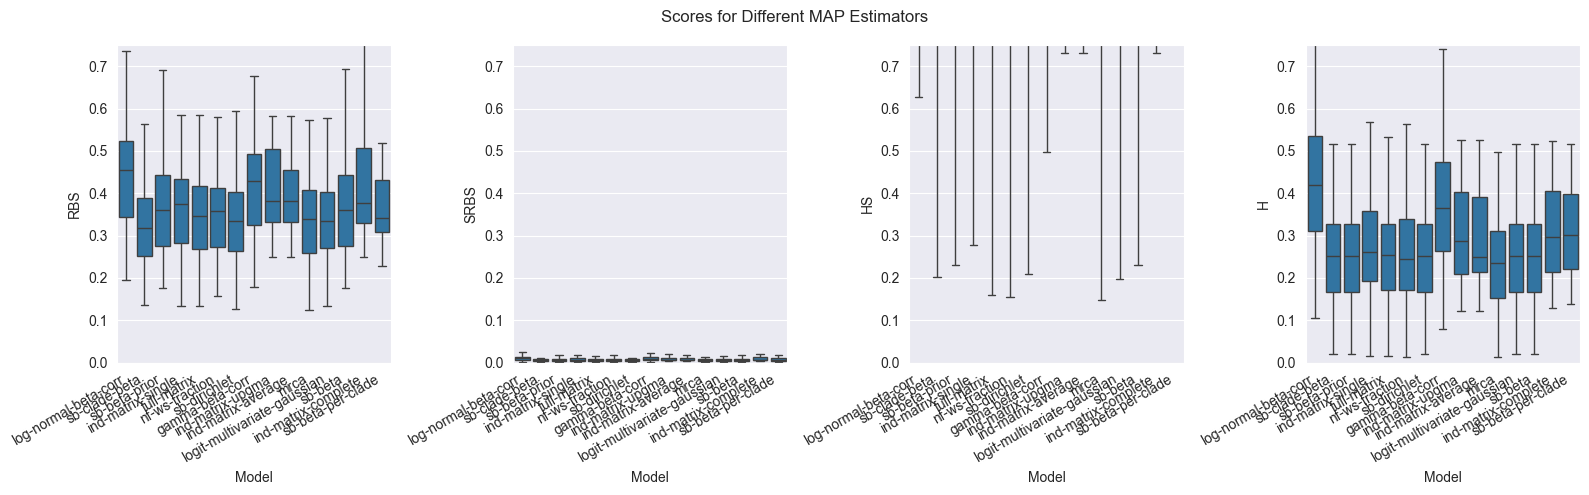

In [12]:
fig, axs = plt.subplots(ncols=NUM_SCORES, figsize=(NUM_SCORES * 4, 5))

for i, score in enumerate(SCORES):
    sns.boxplot(x="model", y=score, data=df_scores, ax=axs[i], fliersize=0, )
    
    axs[i].set_xlabel("Model")
    axs[i].set_xticks(axs[i].get_xticks(), axs[i].get_xticklabels(), rotation=30, ha='right')

    axs[i].set_ylim(0, 0.75)

fig.suptitle("Scores for Different MAP Estimators")
plt.tight_layout()

In [13]:
df_scores[df_scores.dataset == "yule-10"].sort_values(["run", score]).head(10)

,model,dataset,run,RBS,SRBS,HS,H


In [14]:
len(df_score_wins)

NameError: name 'df_score_wins' is not defined

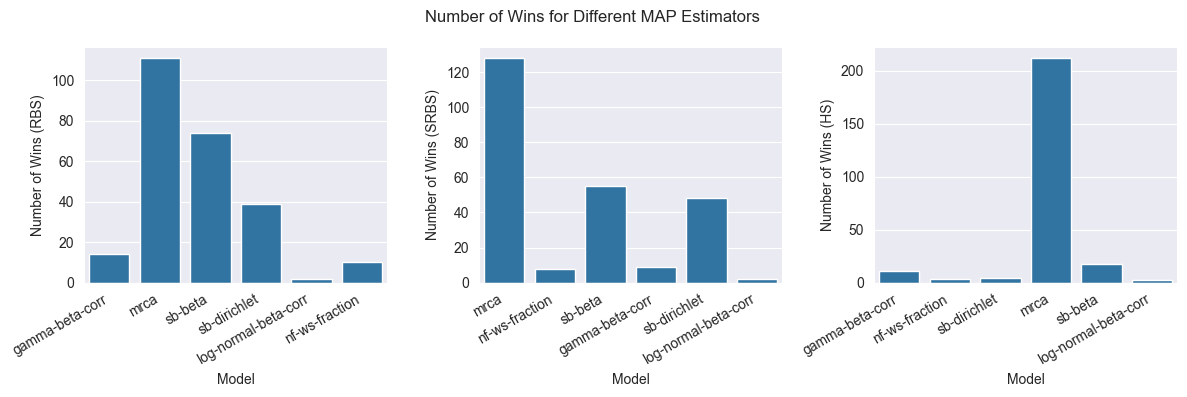

In [ ]:
fig, axs = plt.subplots(ncols=NUM_SCORES, figsize=(4*NUM_SCORES, 4))

for i, score in enumerate(SCORES):
    df_score_wins = df_scores[df_scores.dataset == "yule-10"].sort_values(score).drop_duplicates(["dataset", "run"])
    
    sns.countplot(data=df_score_wins, x="model", ax=axs[i])

    axs[i].set_xlabel("Model")
    axs[i].set_ylabel(f"Number of Wins ({score})")
    axs[i].set_xticks(axs[i].get_xticks(), axs[i].get_xticklabels(), rotation=30, ha='right')

fig.suptitle("Number of Wins for Different MAP Estimators")
plt.tight_layout()

In [ ]:
true_tree = load_trees_from_file(Path("data/mcmc_config/yule-10_10.trees"))[0]
tree_mrca = load_trees_from_file(Path("data/map_data/yule-10_10_10_mrca.trees"))[0]
tree_10 = load_trees_from_file(Path("data/map_data/yule-10_10_10_gamma-beta-corr.trees"))[0]
tree_full = load_trees_from_file(Path("data/map_data/yule-10_10_28652_gamma-beta-corr.trees"))[0]

In [8]:
def rooted_branch_score(tree_1: Tree, tree_2: Tree) -> float:
    taxa_names = get_taxa_names(tree_1)

    nodes_1, _ = get_observed_nodes([tree_1], taxa_names)
    nodes_2, _ = get_observed_nodes([tree_2], taxa_names)

    clades_to_node_1 = {node.node_bitstring: node for node in nodes_1}
    clades_to_node_2 = {node.node_bitstring: node for node in nodes_2}

    rbs = 0.0

    all_clades = set(clades_to_node_1.keys()) | set(clades_to_node_2.keys())

    print(all_clades)

    for clade in all_clades:
        if node_1 := clades_to_node_1.get(clade):
            branch_1 = node_1.height - node_1.parent_height
        else:
            branch_1 = 0.0

        if node_2 := clades_to_node_2.get(clade):
            branch_2 = node_2.height - node_2.parent_height
        else:
            branch_2 = 0.0

        rbs += abs(branch_1 - branch_2)

    return rbs

In [ ]:
rooted_branch_score(tree_10, true_tree), rooted_branch_score(tree_full, true_tree), rooted_branch_score(tree_mrca, true_tree)

{256, 1, 2, 512, 4, 260, 772, 128, 8, 136, 392, 908, 396, 16, 32, 64, 66, 82, 990, 114, 115, 1022, 1023}
{256, 1, 2, 512, 4, 260, 772, 128, 8, 136, 392, 908, 396, 16, 32, 64, 66, 82, 990, 114, 115, 1022, 1023}
{256, 1, 2, 512, 4, 260, 772, 128, 8, 136, 392, 908, 396, 16, 32, 64, 66, 82, 114, 115, 1022, 1023}


(0.2579247165910837, 0.2677082205238662, 0.17870112484166856)

In [28]:
from scipy.special import comb
import numpy as np

def stirling_first_scipy(n, k):
    if k > n:
        return 0
    s = np.zeros((n + 1, k + 1), dtype=int)
    s[0][0] = 1  # Base case

    for i in range(1, n + 1):
        for j in range(1, i + 1):
            s[i][j] = s[i - 1][j - 1] + (i - 1) * s[i - 1][j]

    return s[n][k]

[]

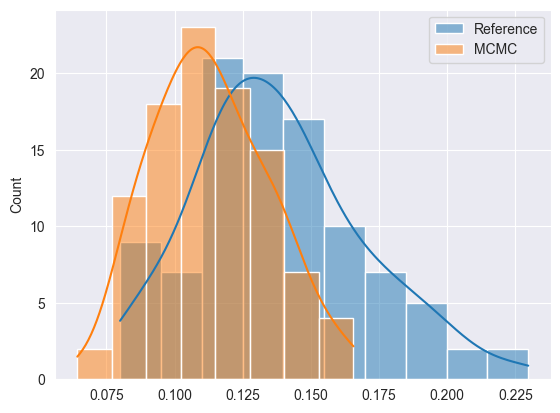

In [104]:
ref_heights = []
map_heights = []
diff = []

for (dataset, run), map_files in list(map_trees_per_dataset.items()):
    reference_tree = load_trees_from_file(REFERENCE_TREE_DIR / f"{dataset}_{run}.trees")[
        0
    ]

    for map_file in map_files:
        file_name_wo_ext = map_file.name.removesuffix(".trees")
        *_, sample_size, model_name = file_name_wo_ext.split("_")

        if int(sample_size) <= 1000:
            # this is not the full dataset
            continue

        if "mrca" not in model_name:
            continue

        if dataset != "yule-50":
            continue

        map_tree = load_trees_from_file(map_file)[0]

        ref_heights.append(reference_tree.distance(reference_tree.root, reference_tree.get_terminals()[0]))
        map_heights.append(get_tree_height(map_tree))
        diff.append(ref_heights[-1] - map_heights[-1])


sns.histplot(ref_heights, kde=True, label="Reference")
sns.histplot(map_heights, kde=True, label="MCMC")
plt.legend()
plt.plot()

In [105]:
np.mean(ref_heights), np.mean(map_heights)

(np.float64(0.13818031826752164), np.float64(0.11307946418707145))

In [107]:
sum([1 / x for x in range(2, 50)]) / 25

0.139168213533177

In [103]:
np.std(ref_heights), np.std(map_heights)

(np.float64(0.028911191371712632), np.float64(0.022934248468883638))

In [65]:
(2 * sum([1 / x for x in range(2, 10)]) - 4 * sum([1 / x**2 for x in range(2, 10)])) / 50

0.029977311665406896

In [112]:
mcmc_trees = load_trees_from_file(Path("data/mcmc_runs") / "yule-50_2.trees")

In [113]:
mcmc_heights = [get_tree_height(tree) for tree in mcmc_trees]

In [114]:
lphy_heights = ref_heights

In [115]:
from scipy import stats

lphy_ranks = [1 - stats.percentileofscore(mcmc_heights, lh) / 100 for lh in lphy_heights]

Text(0.5, 0, 'Fraction of MCMC Trees')

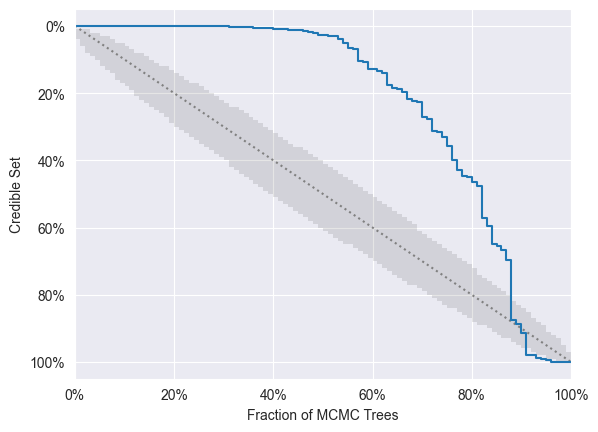

In [116]:
# plot x=y line

from matplotlib.ticker import PercentFormatter


plt.plot([0, 1], [0, 1], color="grey", linestyle="dotted")

# plot ECDF
fig = sns.ecdfplot(y=lphy_ranks)
fig.yaxis.set_major_formatter(PercentFormatter(1))
fig.xaxis.set_major_formatter(PercentFormatter(1))

# plot 95% confidence interval

num_bins = len(lphy_ranks)

for r in range(num_bins):
    lower_bound, upper_bound = stats.binom.interval(0.95, num_bins, r / num_bins)

    rect = plt.Rectangle(  # type: ignore
        (lower_bound / num_bins, r / num_bins),
        upper_bound / num_bins - lower_bound / num_bins,
        1 / num_bins,
        facecolor="black",
        alpha=0.1,
        linewidth=0
    )
    fig.add_patch(rect)

plt.gca().invert_yaxis()

plt.ylabel("Credible Set")
plt.xlabel("Fraction of MCMC Trees")

<Axes: ylabel='Density'>

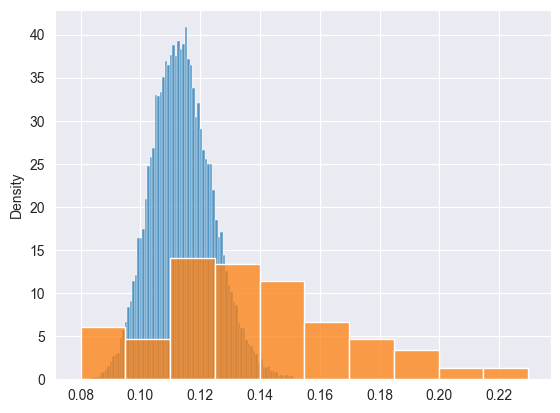

In [117]:
sns.histplot(mcmc_heights, stat="density")
sns.histplot(lphy_heights, stat="density")

In [118]:
np.mean(mcmc_heights), np.mean(lphy_heights)

(np.float64(0.11399317507970282), np.float64(0.13818031826752164))

In [125]:
from tqdm import tqdm

ranks = []

for (dataset, run), map_files in tqdm(list(map_trees_per_dataset.items())): 
    if dataset != "yule-10":
        continue
    
    reference_tree = load_trees_from_file(REFERENCE_TREE_DIR / f"{dataset}_{run}.trees")[
        0
    ]
    mcmc_trees = load_trees_from_file(MCMC_TREE_DIR / f"{dataset}_{run}.trees")

    ref_height = get_tree_height(reference_tree)
    mcmc_heights = [get_tree_height(tree) for tree in mcmc_trees]

    rank = stats.percentileofscore(mcmc_heights, ref_height)
    ranks.append(rank)

100%|██████████| 438/438 [39:53<00:00,  5.46s/it]


<Axes: ylabel='Count'>

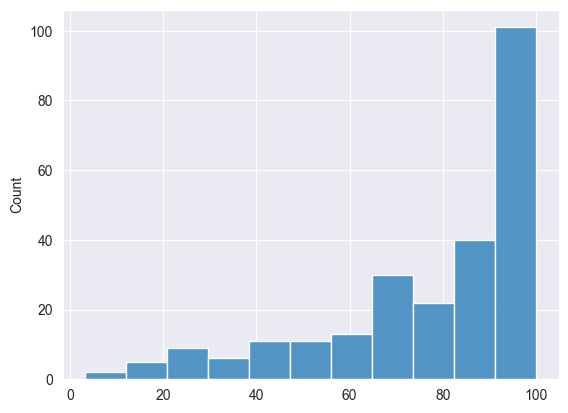

In [127]:
sns.histplot(ranks)

Text(0.5, 0, 'Fraction of Runs')

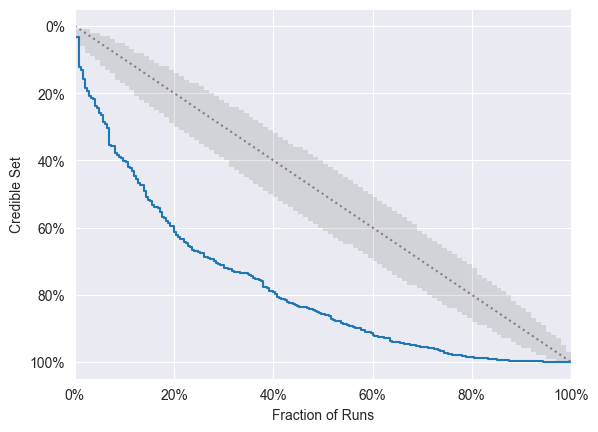

In [130]:
# plot x=y line

from matplotlib.ticker import PercentFormatter


plt.plot([0, 1], [0, 1], color="grey", linestyle="dotted")

# plot ECDF
fig = sns.ecdfplot(y=[r / 100 for r in ranks])
fig.yaxis.set_major_formatter(PercentFormatter(1))
fig.xaxis.set_major_formatter(PercentFormatter(1))

# plot 95% confidence interval

num_bins = len(lphy_ranks)

for r in range(num_bins):
    lower_bound, upper_bound = stats.binom.interval(0.95, num_bins, r / num_bins)

    rect = plt.Rectangle(  # type: ignore
        (lower_bound / num_bins, r / num_bins),
        upper_bound / num_bins - lower_bound / num_bins,
        1 / num_bins,
        facecolor="black",
        alpha=0.1,
        linewidth=0
    )
    fig.add_patch(rect)

plt.gca().invert_yaxis()

plt.ylabel("Credible Set")
plt.xlabel("Fraction of Runs")